<a href="https://colab.research.google.com/github/NMashalov/2023_OpenMipt_course/blob/main/lesson14/sem13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install dowhy -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.7/377.7 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.4/174.4 kB 14.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import networkx as nx
from dowhy import gcm

from dowhy import CausalModel
import dowhy.datasets

import networkx as nx
from IPython.display import Image, display

options = {
    "font_size": 14,
    "node_size": 1500,
    "node_color": "#99FF99",
    "edge_color": "#9999FF",
    "arrowsize": 25,
    "width": 3,
}

def draw_graph(graphs, options):
    nx.draw_networkx(graphs, **options)
    ax = plt.gca()
    ax.margins(0.20)
    plt.axis("off")

sns.set(style='whitegrid', palette='Set2')

---

## Задача 1.

При проведении испытания лекарства получены следующие данные. В каждом случае указано количество успешных случаев.


| Количество успешных        | Принимали плацебо | Принимали лекарство  |
| :------------- |-------------:| -----:|
| Низкое давление      | 81 из 87 | 234 из 270 |
| Высокое давление     | 192 из 263      |   55 из 80 |


Требуется оценить эффект влияния лекарства на успех в двух следующих случаях.

* Кровяное давление пациентов измерялось до начала испытания, после чего принималось решение о приеме лекарства.

* Кровяное давление пациентов измерялось в конце испытания. При этом известно, что лекарство может оказывать эффект на кровяное давление, которое в свою очередь может оказывать эффект на выздоровление.

Часть этой задачи мы уже разобрали на занятии. Сейчас давайте на ее примере разберемся досконально в разных тонкостях.

**1.** Нарисуйте граф причинно-следственных связей для каждого случая.

---

Обозначим
* $X$ &mdash; лечение;
* $Y$ &mdash; результат;
* $Z$ &mdash; давление.


**Первый случай**

Кровяное давление пациентов измерялось до начала испытания, после чего принималось решение о приеме лекарства.
$$p(x, y, z) = p(z)p(x|z)p(y|x, z)$$
$$\widehat{\mathsf{P}}(Z = 1) = \frac{263+80}{263+80+87+270}$$
$$\widehat{\mathsf{P}}(X=1\ |\ Z = 0) = \frac{270}{87+270}$$
$$\widehat{\mathsf{P}}(X=1\ |\ Z = 1) = \frac{80}{263+80}$$
$$\widehat{\mathsf{P}}(Y=1\ |\ X=0, Z = 0) = \frac{81}{87}$$
$$\widehat{\mathsf{P}}(Y=1\ |\ X=1, Z = 0) = \frac{234}{270}$$
$$\widehat{\mathsf{P}}(Y=1\ |\ X=0, Z = 1) = \frac{192}{263}$$
$$\widehat{\mathsf{P}}(Y=1\ |\ X=1, Z = 1) = \frac{55}{80}$$


**Второй случай**

Кровяное давление пациентов измерялось в конце испытания. При этом известно, что лекарство может оказывать эффект на кровяное давление, которое в свою очередь может оказывать эффект на выздоровление.
$$p(x, y, z) = p(x)p(z|x)p(y|x, z)$$
$$\widehat{\mathsf{P}}(X = 1) = \frac{270+80}{263+80+87+270}$$
$$\widehat{\mathsf{P}}(Z=1\ |\ X = 0) = \frac{270}{270+80}$$
$$\widehat{\mathsf{P}}(Z=1\ |\ X = 1) = \frac{80}{270+80}$$
$$\widehat{\mathsf{P}}(Y=1\ |\ X=0, Z = 0) = \frac{81}{87}$$
$$\widehat{\mathsf{P}}(Y=1\ |\ X=1, Z = 0) = \frac{234}{270}$$
$$\widehat{\mathsf{P}}(Y=1\ |\ X=0, Z = 1) = \frac{192}{263}$$
$$\widehat{\mathsf{P}}(Y=1\ |\ X=1, Z = 1) = \frac{55}{80}$$

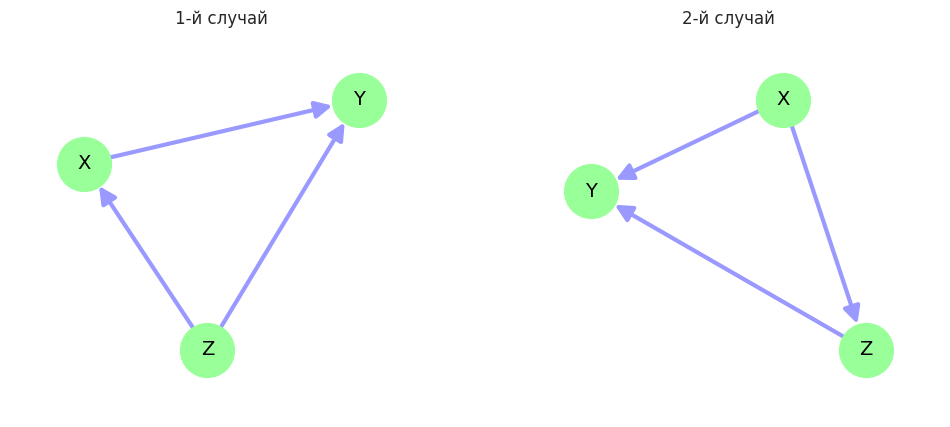

In [3]:
plt.figure(figsize=(12, 5))
# X- лечение, Y - результат, Z - давление
causal_graphs = [
    nx.DiGraph([('Z','X'),('X','Y'),('Z','Y')]), # давление влияло на лечение, лечение и давление влияют на выздоровление
    nx.DiGraph([('X','Z'),('X','Y'),('Z','Y')]), # лечение влияло на давление и выздоровление, давление также влияет на выздоровление
]

for i, graphs in enumerate(causal_graphs):
    plt.subplot(1, 2, i+1)
    draw_graph(graphs, options)
    plt.title(f'{i+1}-й случай')

plt.show()

Создадим датасет.

In [4]:
data = pd.DataFrame()
data['treatment'] = [0]*(87+263) + [1]*(270+80)
data['blood_pressure'] = [0]*87 + [1]*263 + [0]*270 + [1]*80
data['result'] = [1]*81 + [0]*(87-81) + [1]*192 + [0]*(263-192) \
                + [1]*234 + [0]*(270-234) + [1]*55 + [0]*(80-55)
data.index.name = 'patient'

data

,treatment,blood_pressure,result
patient,,,
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
695,1,1,0
696,1,1,0
697,1,1,0



| Количество успешных        | Принимали плацебо X=0 | Принимали лекарство X=1 |
| :------------- |-------------:| -----:|
| Низкое давление Z=0      | 81 из 87 | 234 из 270 |
| Высокое давление Z=1    | 192 из 263      |   55 из 80 |




Постройте графы обоих вариантов в случае интервенции.

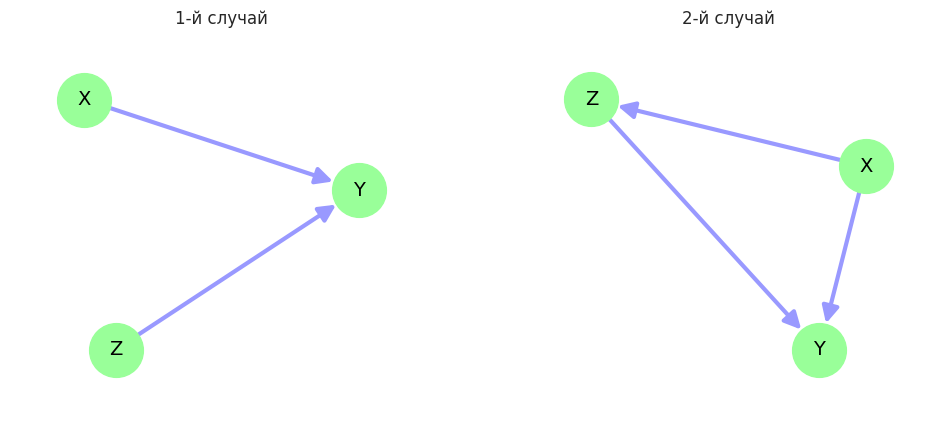

In [5]:
plt.figure(figsize=(12, 5))

# X- лечение, Y - результат, Z - давление
# фиксируем лечение
causal_graphs = [
    nx.DiGraph([('X','Y'),('Z','Y')]), # давление влияло на лечение, лечение и давление влияют на выздоровление
    nx.DiGraph([('X','Z'),('X','Y'),('Z','Y')]), # лечение влияло на давление и выздоровление, давление также влияет на выздоровление
]

for i, graphs in enumerate(causal_graphs):
    plt.subplot(1, 2, i+1)
    draw_graph(graphs, options)
    plt.title(f'{i+1}-й случай')

plt.show()

**2.** Поэкспериментируем с библиотекой DoWhy.

Задайте граф причинно-следственных связей(задайте правильно названия вершин графа) и постройте по нему модель `StructuralCausalModel` с автоматическим определением механизма причинно-следственных связей. Обучите полученную модель.

**Первый случай.**

In [6]:
data.head(2)

,treatment,blood_pressure,result
patient,,,
0,0,0,1
1,0,0,1


In [7]:
causal_graph = nx.DiGraph([('blood_pressure','treatment'),('treatment','result'),('blood_pressure','result')])

In [8]:
from dowhy import gcm
causal_model = gcm.StructuralCausalModel(causal_graph)

In [9]:
gcm.auto.assign_causal_mechanisms(causal_model, data)

gcm.fit(causal_model, data)

Fitting causal mechanism of node result: 100%|██████████| 3/3 [00:00<00:00, 38.05it/s]


Выясните, какие зависимости подобрались и напечатайте параметры этих моделей.

In [10]:
model_X = causal_model.causal_mechanism('treatment')
model_Y = causal_model.causal_mechanism('result')
model_Z = causal_model.causal_mechanism('blood_pressure')

model_X, model_Y, model_Z

(<dowhy.gcm.causal_mechanisms.DiscreteAdditiveNoiseModel at 0x79a1475298a0>,
 <dowhy.gcm.stochastic_models.EmpiricalDistribution at 0x79a147383a90>)

In [11]:
sklearn_model = model_Y.prediction_model.sklearn_model
sklearn_model.coef_, sklearn_model.intercept_

(array([-0.1903959 , -0.05383557]), 0.9230689186715357)

In [12]:
sklearn_model = model_X.prediction_model.sklearn_model
sklearn_model

HistGradientBoostingRegressor()

Как видим, были использованы модели с аддитивным шумом, в то время как наши данные дискретны.

Поменяем тип данных на строковые

In [13]:
data = data.astype(str)

Задайте модели наследования вручную. Если у вершины нет предков, то используйте эмпирическое распределение, иначе &mdash; классификатор `gcm.ClassifierFCM()`. Обучите полученную causal модель.

In [14]:
from dowhy import gcm
causal_model = gcm.StructuralCausalModel(causal_graph)

causal_model.set_causal_mechanism('blood_pressure', gcm.EmpiricalDistribution())
causal_model.set_causal_mechanism('treatment', gcm.ClassifierFCM())
causal_model.set_causal_mechanism('result', gcm.ClassifierFCM())

gcm.fit(causal_model,data)

Fitting causal mechanism of node result: 100%|██████████| 3/3 [00:00<00:00, 18.63it/s]


Наконец, посчитайте оценку ATE с помощью интервенции в построенной модели. Не забудьте, что в качестве значения интервенции нужно указать строку, а полученные семплы перевести обратно в числа перед усреднением.

In [18]:
num_samples_to_draw = 100_000
interventional_mean = []

for i in range(2):
    samples = gcm.interventional_samples(
        causal_model,
        {'treatment': lambda y: str(i) },  # условие интервенции
        num_samples_to_draw=num_samples_to_draw  # количество семплирований
    )
    interventional_mean.append(samples)


ATE = interventional_mean[1]['result'].astype(int).mean() - interventional_mean[0]['result'].astype(int).mean()
ATE

-0.053649999999999975

**Второй случай.**

Задайте модель по аналогии с первым случаем и обучите её.

In [22]:
causal_graph = nx.DiGraph([
    ('treatment','result',),
    ('treatment','blood_pressure'),
    ('blood_pressure','result')
])


causal_model = gcm.StructuralCausalModel(causal_graph)


causal_model.set_causal_mechanism('blood_pressure',gcm.ClassifierFCM())
causal_model.set_causal_mechanism('treatment', gcm.EmpiricalDistribution())
causal_model.set_causal_mechanism('result', gcm.ClassifierFCM())


gcm.fit(causal_model,data)

Fitting causal mechanism of node blood_pressure: 100%|██████████| 3/3 [00:00<00:00, 17.03it/s]


In [24]:
num_samples_to_draw = 100_000
interventional_mean = []

for i in range(2):
    samples = gcm.interventional_samples(
        causal_model,
        {'treatment': lambda y: str(i) },  # условие интервенции
        num_samples_to_draw=num_samples_to_draw  # количество семплирований
    )
    interventional_mean.append(samples)

ATE = interventional_mean[1]['result'].astype(int).mean() - interventional_mean[0]['result'].astype(int).mean()
ATE

0.045009999999999994

**Вывод:**

# Propensity score и работа с ним в библиотеке DoWhy

## Задача 2. Пайплайн оценки


Для оценки эффекта библиотека DoWhy предоставляет четырехступенчатый интерфейс причинно-следственного вывода:
1. Определение модели для причинно-следственной задачи
2. Определение оценщика в рамках модели
3. Оценка причинно-следственной связи по выбранному оценщику
4. Тестирование полученной оценки


### 2.1. Определение модели

```
CausalModel(
    data,
    treatment,
    outcome,
    graph=None,
    common_causes=None,
    instruments=None,
    effect_modifiers=None,
    estimand_type='nonparametric-ate',
    proceed_when_unidentifiable=False,
    missing_nodes_as_confounders=False,
    identify_vars=False,
    **kwargs,
)
```

**Стандартный способ**

Определение причинно-следственной модели на основе данных и заданного графа. Этот граф не обязательно должен быть полным — можно предоставить частичный граф с предварительными знаниями о некоторых признаках. Тогда DoWhy автоматически рассматривает остальные признаким как потенциальные конфаундеры.

Используйте граф случая, где `blood_pressure` является конфаундером.

In [33]:
data = data.astype(float)

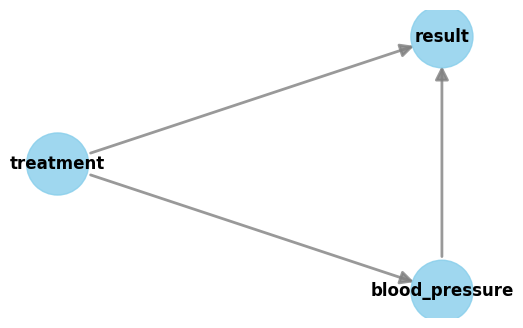

In [34]:
model = CausalModel(
    data=data,
    treatment="treatment",
    outcome="result",
    graph=causal_graph
)

model.view_model(file_name="causal_model", size=(6, 4))
#display(Image(filename="causal_model.png"))
pass

**Другой способ**

Указание ковариат и инструментов в случае наличия.

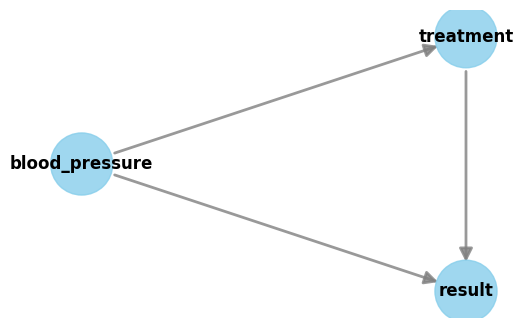

In [35]:
model_2 = CausalModel(
    data=data,
    treatment="treatment",
    outcome="result",
    common_causes="blood_pressure"
)

model_2.view_model(file_name="causal_model", size=(6, 4))
#display(Image(filename="causal_model.png"))

### 2.2. Определение оценщика в рамках модели

Основываясь на причинно-следственном графе, DoWhy находит все возможные способы идентификации желаемого причинно-следственного эффекта на основе графа. Используются критерии на графах и do-исчисление, для поиска всех возможных моделей, которые могут оценить причинно-следственную связь в данном случае.

In [36]:
identified_estimand = model_2.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                               
────────────(E[result|bloodₚᵣₑₛₛᵤᵣₑ])
d[treatment]                         
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→result then P(result|treatment,blood_pressure,U) = P(result|treatment,blood_pressure)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### 2.3. Оценка причинно-следственной связи

```
model.estimate_effect(
    identified_estimand,
    method_name=None,
    control_value=0,
    treatment_value=1,
    test_significance=None,
    evaluate_effect_strength=False,
    confidence_intervals=False,
    target_units='ate',
    effect_modifiers=None,
    fit_estimator=True,
    method_params=None,
)

```


Поддерживаются следущие методы
* Propensity Score Matching: "`backdoor.propensity_score_matching`"
* Propensity Score Stratification: "`backdoor.propensity_score_stratification`" &mdash; использование оценок propensity score для определения бинов, по котором выполняется стратификация
* Propensity Score-based Inverse Weighting: "`backdoor.propensity_score_weighting`"
* Linear Regression: "`backdoor.linear_regression`"
* Generalized Linear Models (e.g., logistic regression): "`backdoor.generalized_linear_model`"
* Instrumental Variables: "`iv.instrumental_variable`"
* Regression Discontinuity: "`iv.regression_discontinuity`"

In [37]:
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_weighting",
)

print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                               
────────────(E[result|bloodₚᵣₑₛₛᵤᵣₑ])
d[treatment]                         
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→result then P(result|treatment,blood_pressure,U) = P(result|treatment,blood_pressure)

## Realized estimand
b: result~treatment+blood_pressure
Target units: ate

## Estimate
Mean value: -0.050337685257286546



Можно извлечь саму оценку причинно-следственного эффекта

In [38]:
estimate.value

-0.050337685257286546

Также можно отдельно построить для нее доверительный интервал

```
estimate.get_confidence_intervals(
    confidence_level=None,
    method=None,
    **kwargs,
)
```

По умолчанию используется формула построения доверительного интервала для конкретного метода. Можно также использовать бутстреп, указав `method='bootstrap'`. Для некоторых методов интервал можно построить только бустрепом, например, для Propensity Score Stratification.

In [39]:
%%time
estimate.get_confidence_intervals()

CPU times: user 6.49 s, sys: 80.8 ms, total: 6.57 s
Wall time: 6.56 s


(-0.10888649568667463, 0.0091258736283506)

И проверить стат. значимость отличия от нуля, получив p-value. Здесь также можно использовать бутстреп

In [40]:
%%time
estimate.test_stat_significance()

CPU times: user 19.1 s, sys: 129 ms, total: 19.3 s
Wall time: 19.5 s


{'p_value': 0.064}

Также можно извлечь оценку стандартного отклонения

In [41]:
estimate.get_standard_error()

0.03625134558698228

Оценка произведена с помощью следующей формулы

In [42]:
estimate.realized_estimand_expr

'b: result~treatment+blood_pressure'

Также можно посмотреть на то, какие признаки использованы

In [43]:
estimate.target_estimand.treatment_variable

['treatment']

### 2.4. Тестирование полученной оценки

```
model.refute_estimate(
    estimand,
    estimate,
    method_name=None,
    show_progress_bar=False,
    **kwargs,
)
```

Одно из основных преимущество DoWhy &mdash; несколько методов проверки устойчивости моделей.

Поддерживаемые методы опровержения
* **Добавить рандомный конфаундер:** Изменяет ли метод свою оценку добавления конфаундера-рандом в набор данных?
    * *так не должно быть*

* **Тритмент:** Что происходит с предполагаемым причинно-следственным эффектом, если мы тритмент заменим на рандом?
    * *эффект должен быть равен нулю*

* **Фиктивный результат:** Что происходит с предполагаемым причинно-следственным эффектом, при замене таргета на рандом?
    * *эффект должен быть равен нулю*

* **Моделирование:** Что происходит с предполагаемым причинно-следственным эффектом, при замене реального набора данных на искусственный, наиболее похожий по отношению к данному набору данных?
    * *он должен соответствовать параметру effect из процесса генерации данных*

* **Добавить ненаблюдаемый конфаундер:** Насколько чувствительна оценка эффекта при дополнительного конфаундера?
    * *она не должен быть слишком чувствительным*

* **Проверка подмножеств данных:** Существенно ли изменяется оцененный эффект при замене данных на случайно выбранное подмножество?
    * *так не должно быть*

* **Проверка бутстрепом:** Существенно ли меняется предполагаемый эффект при замене данных на бутстрепные рализации?
    * *так не должно быть*


In [44]:
refute_results = model.refute_estimate(
    identified_estimand, estimate,
    method_name="random_common_cause",
    show_progress_bar=True
)

print(refute_results)

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

Refute: Add a random common cause
Estimated effect:-0.050337685257286546
New effect:-0.05033768525728654
p value:1.0



In [45]:
refute_results = model.refute_estimate(
    identified_estimand, estimate,
    method_name="add_unobserved_common_cause",
    show_progress_bar=True
)

print(refute_results)

Refute: Add an Unobserved Common Cause
Estimated effect:-0.050337685257286546
New effect:-0.026729364648139686



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [46]:
refute_results = model.refute_estimate(
    identified_estimand, estimate,
    method_name="placebo_treatment_refuter",
    show_progress_bar=True
)

print(refute_results)

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/propensity_score_weighting_estimator.py:245: RuntimeWarning: invalid value encountered in double_scalars
  est = data["d_y"].sum() / sum_dy_weights - data["dbar_y"].sum() / sum_dbary_weights
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/propensity_score_weighting_estimator.py:245: RuntimeWarning: invalid value encountered in double_scalars
  est = data["d_y"].sum() / sum_dy_weights - data["dbar_y"].sum() / sum_dbary_weights
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/propensity_score_weighting_estimator.py:245: RuntimeWarning: invalid value encountered in double_scalars
  est = data["d_y"].sum() / sum_dy_weights - data["dbar_y"].sum() / sum_dbary_weights
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/propensity_score_weighting_estimator.py:245: RuntimeWarning: invalid value encountered in double_scalars
  est = data["d_y"].sum() / sum_dy_weights - data["dbar_y"].sum() 

Refute: Use a Placebo Treatment
Estimated effect:-0.050337685257286546
New effect:nan
p value:0.0



/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/propensity_score_weighting_estimator.py:245: RuntimeWarning: invalid value encountered in double_scalars
  est = data["d_y"].sum() / sum_dy_weights - data["dbar_y"].sum() / sum_dbary_weights
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/propensity_score_weighting_estimator.py:245: RuntimeWarning: invalid value encountered in double_scalars
  est = data["d_y"].sum() / sum_dy_weights - data["dbar_y"].sum() / sum_dbary_weights
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/propensity_score_weighting_estimator.py:245: RuntimeWarning: invalid value encountered in double_scalars
  est = data["d_y"].sum() / sum_dy_weights - data["dbar_y"].sum() / sum_dbary_weights


In [47]:
refute_results = model.refute_estimate(
    identified_estimand, estimate,
    method_name="data_subset_refuter",
    show_progress_bar=True
)

print(refute_results)

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

Refute: Use a subset of data
Estimated effect:-0.050337685257286546
New effect:-0.05224513757932712
p value:0.92



**Вывод:**